In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(phyloseq)
library(dplyr)
library(ggplot2)
library(readr)

In [5]:
%%R
otu_tab = read_csv("data/EC_table.noMC.csv") %>% {
    rownames(.) = .$seq_id
    .
    } %>%
    select(-seq_id) %>%
    as.matrix %>%
    otu_table(taxa_are_rows = TRUE)

tax_tab = read_csv("data/tax_table.csv") %>% {
    rownames(.) = .$seq_id
    .
    } %>%
    select(-seq_id) %>%
    as.matrix %>%
    tax_table

sample_tab = read_csv("data/sample_data.csv") %>% {
    rownames(.) = .$sample
    .
    } %>%
    select(-sample) %>%
    data.frame %>%
    sample_data

tree = phy_tree(ape::read.tree("data/variants.tree"))

ps = phyloseq(otu_tab, tax_tab, sample_tab, tree) %>% 
    prune_samples((sampleSums(.) > 1000)&
                  (sample_data(.)$star == "star"), .) %>%
    transform_sample_counts(function(x) x / sum(x))

ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9292 taxa and 75 samples ]
sample_data() Sample Data:       [ 75 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 9292 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9292 tips and 9288 internal nodes ]


In [ ]:
%%R
mdf = psmelt(ps)
mdf %>% head

### Rank Abundance of RSVs

In [50]:
%%R
mdf.R = mdf %>%
    group_by(Sample,Rank1,Rank2,Rank3) %>%
    mutate(R = rank(desc(Abundance), ties.method = "random")) %>%
    select(OTU, Sample, R, Abundance,Rank1,Rank2,Rank3)

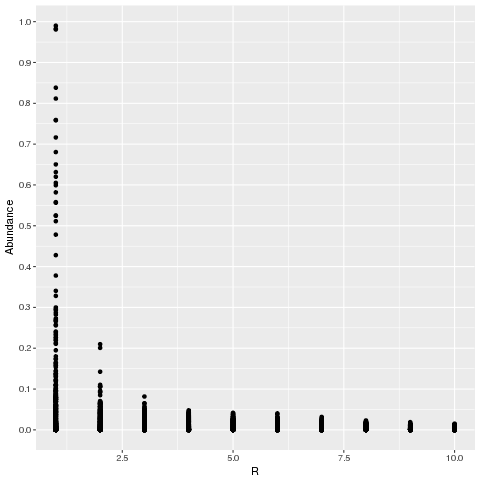

In [136]:
%%R

p = ggplot(mdf.R, aes(x = R, y = Abundance, group = Sample))

p = p + geom_point() + xlim(1,10)

p = p + scale_y_continuous(breaks=seq(0, 1, 0.1))

p

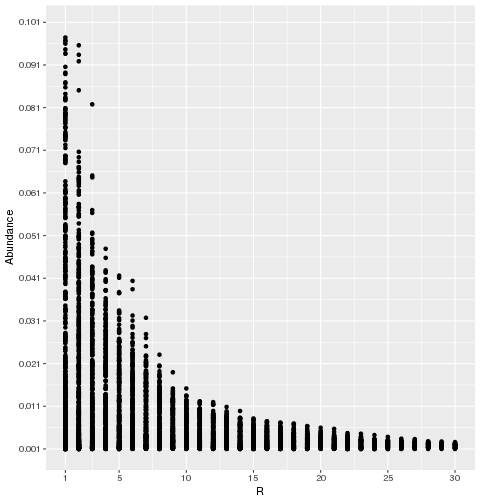

In [177]:
%%R -h 300 -h 500

p = ggplot(mdf.R[which(mdf.R$Abundance<=0.1),],aes(x = R, y = Abundance, group = Sample))

p = p + geom_point()

#p = p + scale_x_log10()# + scale_y_log10()

p = p + scale_y_continuous(limits = c(0.001,0.1), breaks=seq(0.001, 1, 0.01))

p = p + scale_x_continuous(limits = c(1,30), breaks=c(1,5,10,15,20,25,30))

p

### Prevalence

In [561]:
%%R

prev0 = apply(X = otu_table(ps),
                MARGIN = ifelse(taxa_are_rows(ps), yes = 1, no = 2),
                FUN = function(x){sum(x > 0)})
prevdf = data.frame(Prevalence = prev0, OTU=taxa_names(ps))


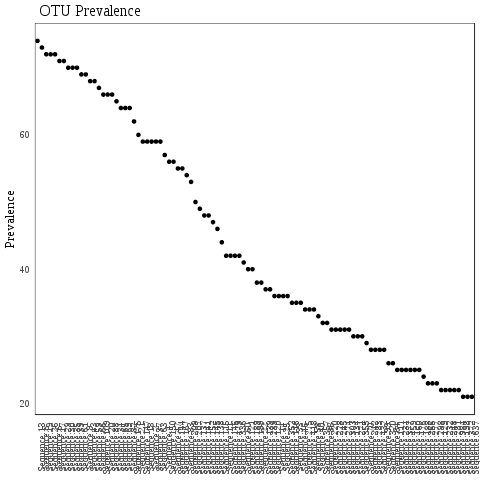

In [606]:
%%R
p = ggplot(prevdf[which(prevdf$Prevalence>20),],aes(x = reorder(OTU,-Prevalence), y = Prevalence))

p = p + geom_point() + ggtitle(" OTU Prevalence")

p = p + theme_bw() + theme(axis.text.x = element_text(angle = 90),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           text=element_text(size=13, color="black", family="Times New Roman"),
                           axis.ticks = element_blank(),
                           #axis.text.x = element_blank(),
                           axis.title.x = element_blank())

p

### Average Relative Abundance of RSV

In [751]:
%%R

topN = mdf %>%   
    inner_join(prevdf,by="OTU") %>%
    group_by(Sample,Prevalence,OTU,Rank2,Rank3,Rank4,Rank5,Rank6) %>%
    summarise(Abundance = sum(Abundance)) %>%
    group_by(OTU,Prevalence,Rank2,Rank3,Rank4,Rank5,Rank6) %>%
    summarise(mean =  mean(Abundance),
              sd = sd(Abundance),
              sem = sd/sqrt(length(Abundance)),
              proportion = round(mean*100,2)) %>%
    arrange(desc(mean))

In [752]:
%%R
write.csv(topN, file = "supplementarytable3.csv")

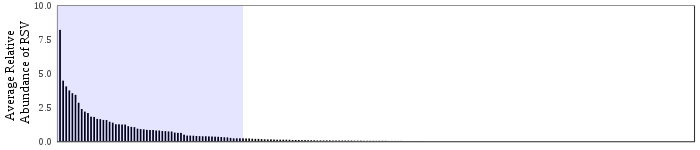

In [690]:
%%R -w 700 -h 150
###top 200 RSVs
p = ggplot(topN[which(topN$mean>0.0003),],aes(x = reorder(OTU,-proportion), y = proportion))

p = p + geom_bar(fill = "black",stat="identity",colour="white")

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           text=element_text(size=13, color="black", family="Times New Roman"),
                           axis.ticks = element_blank(),
                           axis.text.x = element_blank(),
                           axis.title.x = element_blank())

p = p + scale_y_continuous(expand = c(0,0),limits = c(0, 10))# + scale_fill_brewer(palette = "Set3")

#p = p + guides(fill=guide_legend(ncol=2))

p = p + annotate("rect", fill = "blue", alpha = 0.1, 
        xmin = 0, xmax = 60 ,
        ymin = 0, ymax = 10) 

p = p + ylab("Average Relative \n Abundance of RSV")

p

### Sequences in Heat Map plot

In [ ]:
array(['Sequence.4', 'Sequence.6', 'Sequence.5', 'Sequence.12',
       'Sequence.9', 'Sequence.8', 'Sequence.2', 'Sequence.24',
       'Sequence.1', 'Sequence.13', 'Sequence.16', 'Sequence.17',
       'Sequence.21', 'Sequence.19', 'Sequence.11', 'Sequence.18',
       'Sequence.14', 'Sequence.36', 'Sequence.30', 'Sequence.26',
       'Sequence.44', 'Sequence.41', 'Sequence.20', 'Sequence.23',
       'Sequence.37', 'Sequence.39', 'Sequence.54', 'Sequence.43',
       'Sequence.48', 'Sequence.7', 'Sequence.29', 'Sequence.25',
       'Sequence.33', 'Sequence.35', 'Sequence.57', 'Sequence.22',
       'Sequence.56', 'Sequence.59', 'Sequence.38', 'Sequence.34',
       'Sequence.83', 'Sequence.66', 'Sequence.49', 'Sequence.108',
       'Sequence.47', 'Sequence.65', 'Sequence.42', 'Sequence.63',
       'Sequence.46', 'Sequence.61', 'Sequence.69', 'Sequence.60',
       'Sequence.40', 'Sequence.82', 'Sequence.58', 'Sequence.100',
       'Sequence.122', 'Sequence.88', 'Sequence.70', 'Sequence.109'], dtype=object)

### Chart average relative abundance (Y axis) versus prevalence for all RSVs and for our Top RSV (X axis)

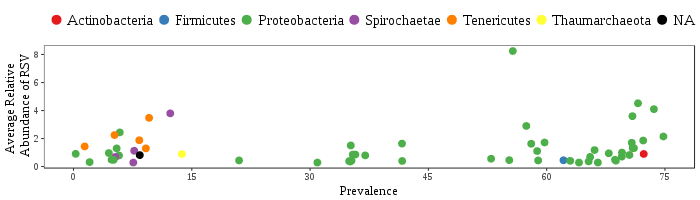

In [764]:
%%R -w 700 -h 200

p = ggplot(topN[which(topN$mean>0.00285),], aes(x = Prevalence, y = proportion))

p = p + geom_point(aes(color = Rank2),size=3,position = position_jitter(h = 0, w = 2))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position = "top",
                           legend.text = element_text(size=15),
                           legend.title = element_blank(),
                           text=element_text(size=13, color="black", family="Times New Roman"))

p = p + ylab("Average Relative \n Abundance of RSV") + scale_color_brewer(palette = "Set1",na.value = "black")

p = p + guides(colour = guide_legend(override.aes = list(size=4),nrow=1))

p = p + scale_x_continuous(limits = c(0,75), breaks=c(0,15,30,45,60,75))

p